# Hybrid Laplace-Fourier Neural Operator

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import time
from timeit import default_timer
from Utilities_Laplace import MatReader
from utilities import EarlyStopping

import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

Calculate transient response (Adaptive Laplace Kernel)

In [4]:
class Transient(nn.Module):
    def __init__(self, in_channels, out_channels, modes11, modes12):
        super(Transient, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes11 = modes11
        self.modes12 = modes12
        self.scale = (1 / (in_channels * out_channels))

        # Laplace operator parameters
        self.weights_residue = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes11, self.modes12, dtype=torch.cfloat)
        )

        # NEW: Adaptive Laplace coefficient (trainable)
        self.alpha = nn.Parameter(torch.tensor(1.0))

    def compl_mul2d(self, input, weights):
        # Complex multiplication in 2D
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        B, C, H, W = x.shape
        # Fourier transform
        x_ft = torch.fft.rfft2(x)

        # Initialize output in Fourier space
        out_ft = torch.zeros(
            B, self.out_channels, H, W // 2 + 1,
            device=x.device, dtype=torch.cfloat
        )

        # Apply Laplace weights
        out_ft[:, :, :self.modes11, :self.modes12] = self.compl_mul2d(
            x_ft[:, :, :self.modes11, :self.modes12], self.weights_residue
        )

        # Inverse FFT
        x_out = torch.fft.irfft2(out_ft, s=(H, W))

        # Adaptive scaling
        return self.alpha * x_out


Calculate steady-state response, which is same to the Fourier layer

In [5]:
class Steady(nn.Module):
    def __init__(self, in_channels, out_channels, modes21, modes22):
        super(Steady, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes21 = modes21
        self.modes22 = modes22
        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes21, self.modes22, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes21, self.modes22, dtype=torch.cfloat))

    def forward(self, x):
        ## 2 Computing Steady-state part
        x = x[:,:,::2,::2]
        tx=T[:,::2].cuda()
        ty=X[:,::2].cuda()
        dty=(ty[0,1]-ty[0,0]).item()  # location interval
        dtx=(tx[0,1]-tx[0,0]).item()  # time interval
        FW1 = torch.fft.rfft2(x)
        omega1=torch.fft.fftfreq(ty.shape[1], dty)*2*np.pi*1j   # location frequency
        omega2=torch.fft.rfftfreq(tx.shape[1], dtx)*2*np.pi*1j   # time frequency
        lambda1=omega1.cuda()
        lambda2=omega2.cuda() 

        out_2 = torch.zeros(x.shape[0], self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_2[:, :, :self.modes21, :self.modes22] = \
            torch.einsum("bixy,ioxy->boxy", FW1[:, :, :self.modes21, :self.modes22], self.weights1)
        out_2[:, :, -self.modes21:, :self.modes22] = \
            torch.einsum("bixy,ioxy->boxy", FW1[:, :, -self.modes21:, :self.modes22], self.weights2)
        
        #Return to physical space
        tx_out=T.cuda()
        ty_out=X.cuda()
        term4=torch.einsum("xk,kz->xz", lambda1.reshape(-1,1), ty_out.type(torch.complex64).reshape(1,-1))
        term5=torch.einsum("bk,ki->bi", lambda2.reshape(-1,1), tx_out.type(torch.complex64).reshape(1,-1))
        term6=torch.einsum("xz,bi->xbzi", torch.exp(term4),torch.exp(term5))
        x2=torch.einsum("pqxb,xbzi->pqzi", out_2,term6)
        x2=torch.real(x2)
        x2=x2/x.size(-1)/x.size(-2)
        return x2

Hybrid Laplace + Fourier Operator

In [6]:
class HybridOperator(nn.Module):
    def __init__(self, in_channels, out_channels, modes_laplace, modes_fourier):
        super(HybridOperator, self).__init__()
        
        # Laplace block (Adaptive)
        self.laplace = Transient(in_channels, out_channels, modes_laplace, modes_fourier)
        
        # Fourier block (Steady, unchanged)
        self.fourier = Steady(in_channels, out_channels, modes_fourier, modes_fourier)
        
        # Fusion (learnable 1x1 conv to mix channels)
        self.fusion = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        laplace_out = self.laplace(x)
        fourier_out = self.fourier(x)
        
        # Combine both
        out = laplace_out + fourier_out
        out = self.fusion(out)
        return out


Operator Selection Flag   
Options: 'laplace', 'fourier', 'hybrid'

In [7]:
operator_choice = 'hybrid'

def get_operator(in_channels, out_channels, modes1=12, modes2=None):
    if modes2 is None:
        modes2 = modes1

    if operator_choice == 'laplace':
        return Transient(in_channels, out_channels, modes1, modes2)
    elif operator_choice == 'fourier':
        return Steady(in_channels, out_channels, modes1, modes2)
    elif operator_choice == 'hybrid':
        return HybridOperator(in_channels, out_channels, modes1, modes2)
    else:
        raise ValueError(f"Unknown operator_choice: {operator_choice}")

print(f" Using operator: {operator_choice}")


 Using operator: hybrid


In [ ]:
class LNO2d(nn.Module):
    def __init__(self, width1,width2,width3,modes11,modes12,modes21,modes22):
        super(LNO2d, self).__init__()

        self.width1 = width1
        self.width2 = width2
        self.width3 = width3
        self.modes11 = modes11
        self.modes12 = modes12
        self.modes21 = modes21
        self.modes22 = modes22

        self.fc2 = nn.Linear(3, self.width2) 
        self.conv_s0 = Steady(self.width2, self.width2, modes21,modes22)
        self.conv_s1 = Steady(self.width2, self.width2, modes21,modes22)
        self.conv_s2 = Steady(self.width2, self.width2, modes21,modes22)
        self.conv_s3 = Steady(self.width2, self.width2, modes21,modes22)
        self.w0 = nn.Conv2d(self.width3, self.width3, 1)
        self.w1 = nn.Conv2d(self.width3, self.width3, 1)
        self.w2 = nn.Conv2d(self.width3, self.width3, 1)
        self.w3 = nn.Conv2d(self.width3, self.width3, 1)
        self.norm2 = nn.InstanceNorm2d(self.width2)
        self.fc5 = nn.Linear(self.width2, 128)
        self.fc8 = nn.Linear(128, 1)
        self.fc1 = nn.Linear(3, self.width1) 
        self.conv_t0 = Transient(self.width1, self.width1, modes11,modes12)
        self.conv_t1 = Transient(self.width1, self.width1, modes11,modes12)
        self.conv_t2 = Transient(self.width1, self.width1, modes11,modes12)
        self.conv_t3 = Transient(self.width1, self.width1, modes11,modes12)
        self.norm1 = nn.InstanceNorm2d(self.width1)
        self.fc4 = nn.Linear(self.width1, 128)
        self.fc7 = nn.Linear(128, 1)


#  The total output includes three parts: transient part, steady-state part and W part. 
#  One can choose how to combine them in this part according to the problem
    def forward(self,f):
        grid = self.get_grid(f.shape, f.device)
        f = torch.cat((f, grid), dim=-1)

        # # # # # Transient part
        f1 = self.fc1(f)
        f1 = f1.permute(0, 3, 1, 2)
        x1 = self.norm1(self.conv_t0(self.norm1(f1)))
        x1 =  torch.sin(x1)
        x1 = self.norm1(self.conv_t1(self.norm1(x1)))
        x1 =  torch.sin(x1)
        x1 = self.norm1(self.conv_t2(self.norm1(x1)))
        x1 =  torch.sin(x1)
        x1 = self.norm1(self.conv_t3(self.norm1(x1)))
        x1 = x1.permute(0, 2, 3, 1)
        x1 = self.fc4(x1)
        x1 =  torch.sin(x1)
        x1 = self.fc7(x1)

        # Steady-state part + W part
        f2 = self.fc2(f)
        f2 = f2.permute(0, 3, 1, 2)
        x2 = self.norm2(self.conv_s0(self.norm2(f2)))
        x23=x2
        x23 =  torch.sin(x23)

        x2 = self.norm2(self.conv_s1(self.norm2(x23)))
        x3 = self.w1(x23)
        x23=x2+x3
        x23 =  torch.sin(x23)

        x2 = self.norm2(self.conv_s2(self.norm2(x23)))
        x3 = self.w2(x23)
        x23=x2+x3
        x23 =  torch.sin(x23)

        x2 = self.norm2(self.conv_s3(self.norm2(x23)))
        x3 = self.w3(x23)
        x23=x2+x3

        x23 = x23.permute(0, 2, 3, 1)
        x23 = self.fc5(x23)
        x23 =  torch.sin(x23)
        x23 = self.fc8(x23)

        return x1+x23

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

Define parameters and Load data

In [ ]:
ntrain = 800
nvali = 100
ntest = 100

batch_size_train = 10
batch_size_vali = 10

learning_rate = 0.00001
epochs = 1000
step_size = 100
gamma = 0.5

modes11 =4
modes12 = 4
modes21 = 4
modes22 = 4
width1 = 16
width2 = 16
width3 = 16

reader = MatReader('data/2D_Burger.mat')
T = reader.read_field('t')
X = reader.read_field('x')

x_train = reader.read_field('f_train')
y_train = reader.read_field('u_train')
for idx1 in range(x_train.shape[1]):
    for idx2 in range(x_train.shape[2]):
        if idx1 % 2 != 0 and idx2 % 2 != 0:
            x_train[:, idx1, idx2] = 0

x_vali = reader.read_field('f_vali')
y_vali = reader.read_field('u_vali')
for idx1 in range(x_vali.shape[1]):
    for idx2 in range(x_vali.shape[2]):
        if idx1 % 2 != 0 and idx2 % 2 != 0:
            x_vali[:, idx1, idx2] = 0

x_test = reader.read_field('f_test')
y_test = reader.read_field('u_test')
for idx1 in range(x_test.shape[1]):
    for idx2 in range(x_test.shape[2]):
        if idx1 % 2 != 0 and idx2 % 2 != 0:
            x_test[:, idx1, idx2] = 0

x_train = x_train.reshape(ntrain,x_train.shape[1],x_train.shape[2],1)
x_vali = x_vali.reshape(nvali,x_vali.shape[1],x_vali.shape[2],1)
x_test = x_test.reshape(ntest,x_test.shape[1],x_test.shape[2],1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size_train, shuffle=True)
vali_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_vali, y_vali), batch_size=batch_size_vali, shuffle=False)

In [11]:
model = LNO2d(width1, width2, width3, modes11, modes12, modes21, modes22).cuda()
print(f'Training started with operator: {operator_choice}')

Training started with operator: hybrid


Training 

In [12]:
os.makedirs('models/laplace2d_hybrid', exist_ok=True)

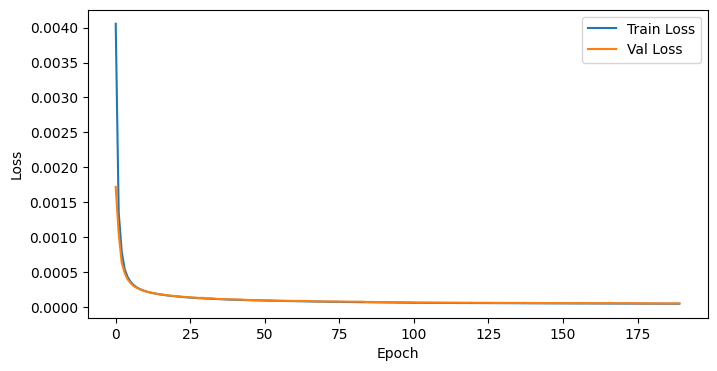

EarlyStopping counter: 5 out of 5
We are at epoch: 189
Training done...
Training time: 372.678


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
early_stopping = EarlyStopping(patience=5, verbose=True, path='models/laplace2d_hybrid/laplace2d_hybrid_checkpoint.pt', trace_func=print)

start_time = time.time()
mse=nn.MSELoss()


train_losses=[]
val_losses=[]

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)   
        mse_loss = mse(out.view(-1,x_train.shape[1],x_train.shape[2]), y)
        mse_loss.backward()

        optimizer.step()
        train_mse += mse_loss.item()

    scheduler.step()
    model.eval()
    vali_mse = 0.0
    with torch.no_grad():
        for x, y in vali_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x)
            vali_mse += mse(out.view(-1,x_vali.shape[1],x_vali.shape[2]), y).item()

    train_mse /= ntrain
    vali_mse /= nvali
    t2 = default_timer()
    train_losses.append(train_mse)
    val_losses.append(vali_mse)
    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # early stopping
    early_stopping(val_loss=vali_mse,model=model)
    if early_stopping.early_stop:
        print("We are at epoch:", ep)
        break
    print(f"Epoch {ep:03d} | time {t2-t1:.3f}s | train_mse {train_mse:.6e} | val_mse: {vali_mse:.6e}")

elapsed = time.time() - start_time
print("Training done...")
print('Training time: %.3f'%(elapsed))

In [15]:
# === Evaluation & Metrics (per-sample + aggregate) ===
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os


# Ensure eval mode
model.eval()
preds = []
gts = []
rel_l2_list = []
mse_list = []
mae_list = []
rmse_list = []
r2_list = []
loss_data=[]

with torch.no_grad():
    for idx, (x, y) in enumerate(zip(x_test, y_test)):
        x= x.unsqueeze(0).cuda()
        out = model(x).cpu() 
        gts.append(y.numpy())
        preds.append(out.numpy())
        mse = mean_squared_error(y.flatten(), out.flatten())
        mae = mean_absolute_error(y.flatten(), out.flatten())
        rmse = np.sqrt(mse)
        r2 = r2_score(y.flatten(), out.flatten())

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
        loss_data.append({'idx':idx, 'mse':mse, 'mae':mae, 'rmse':rmse, 'r2':r2})
        print(f"Sample {idx:3d} | MSE: {mse:.6e} | RMSE: {rmse:.6e} | MAE: {mae:.6e} | R2: {r2:.4f}")


# summary
def summarize(metric_list, name):
    arr = np.array(metric_list)
    print(f"{name:10s} => mean: {np.mean(arr):.6e}    std: {np.std(arr):.6e}    median: {np.median(arr):.6e}")

print("\\n=== Summary over test set ===")
summarize(rel_l2_list, "rel-L2")
summarize(mse_list,   "MSE")
summarize(rmse_list,  "RMSE")
summarize(mae_list,   "MAE")
summarize(r2_list,    "R2")

# # save results to .mat
# sio.savemat('pred/burger_test_metrics.mat', {
#     'pred': preds, 'gt': gts,
#     'rel_l2_list': np.array(rel_l2_list),
#     'mse_list': np.array(mse_list),
#     'mae_list': np.array(mae_list),
#     'rmse_list': np.array(rmse_list),
#     'r2_list': np.array(r2_list)
# })
# print("Saved predictions + metrics to pred/burger_test_metrics.mat")


Sample   0 | MSE: 6.364199e-05 | RMSE: 7.977593e-03 | MAE: 6.000251e-03 | R2: 0.9907
Sample   1 | MSE: 5.383274e-04 | RMSE: 2.320188e-02 | MAE: 1.290576e-02 | R2: 0.9935
Sample   2 | MSE: 1.765024e-03 | RMSE: 4.201218e-02 | MAE: 1.926691e-02 | R2: 0.9863
Sample   3 | MSE: 2.468780e-04 | RMSE: 1.571235e-02 | MAE: 1.146281e-02 | R2: 0.9876
Sample   4 | MSE: 5.928999e-04 | RMSE: 2.434954e-02 | MAE: 1.505792e-02 | R2: 0.9926
Sample   5 | MSE: 6.757677e-04 | RMSE: 2.599553e-02 | MAE: 1.395868e-02 | R2: 0.9934
Sample   6 | MSE: 1.136613e-04 | RMSE: 1.066121e-02 | MAE: 8.308819e-03 | R2: 0.9847
Sample   7 | MSE: 3.248774e-04 | RMSE: 1.802435e-02 | MAE: 1.165648e-02 | R2: 0.9913
Sample   8 | MSE: 1.023175e-04 | RMSE: 1.011521e-02 | MAE: 7.567184e-03 | R2: 0.9940
Sample   9 | MSE: 6.504795e-04 | RMSE: 2.550450e-02 | MAE: 1.589564e-02 | R2: 0.9875
Sample  10 | MSE: 2.569041e-04 | RMSE: 1.602823e-02 | MAE: 1.083013e-02 | R2: 0.9934
Sample  11 | MSE: 3.998079e-04 | RMSE: 1.999520e-02 | MAE: 1.4019

/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
import pandas as pd
loss_df = pd.DataFrame(loss_data)

In [17]:
results={
    'mse':np.mean(mse_list),
    'rmse':np.mean(rmse_list),
    'mae':np.mean(mae_list),
    'r2':np.mean(r2_list),
    'pred': np.array(preds).reshape((-1,)+gts[1].shape), 'gts':np.array(gts),
    'rel_l2_list': np.array(rel_l2_list),
    'mse_list': np.array(mse_list),
    'mae_list': np.array(mae_list),
    'rmse_list': np.array(rmse_list),
    'r2_list': np.array(r2_list)
}
import pickle
pickle.dump(results, open('models/laplace2d_hybrid/burger_test_metrics.pickle', 'wb'))

In [18]:
results=pickle.load(open('models/laplace2d_hybrid/burger_test_metrics.pickle', 'rb'))

In [19]:
preds=results['pred']
gts=results['gts']

In [21]:
gts.shape, preds.shape

((100, 64, 50), (100, 64, 50))

In [26]:
min_loss_idx = loss_df[loss_df['mse'] == loss_df['mse'].min()]['idx'].values[0]
max_loss_idx = loss_df[loss_df['mse'] == loss_df['mse'].max()]['idx'].values[0]
min_loss_idx, max_loss_idx

(np.int64(0), np.int64(75))

In [27]:
def plot_comparison(idx):
    f,ax=plt.subplots(1,3,figsize=(15,5))
    plt.suptitle(f"Loss Comparison MSE: {loss_df.iloc[idx]['mse']:.6e}")
    ax[0].imshow(gts[idx].squeeze(), cmap='viridis')
    ax[0].set_title('Ground Truth')
    ax[1].imshow(preds[idx].squeeze(), cmap='viridis')
    ax[1].set_title('Prediction')
    ax[2].imshow(F.mse_loss(torch.tensor(gts[idx]),torch.tensor(preds[idx]),reduce=False).cpu().numpy(), cmap='bwr')
    ax[2].set_title('Error (MSE)')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()

/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


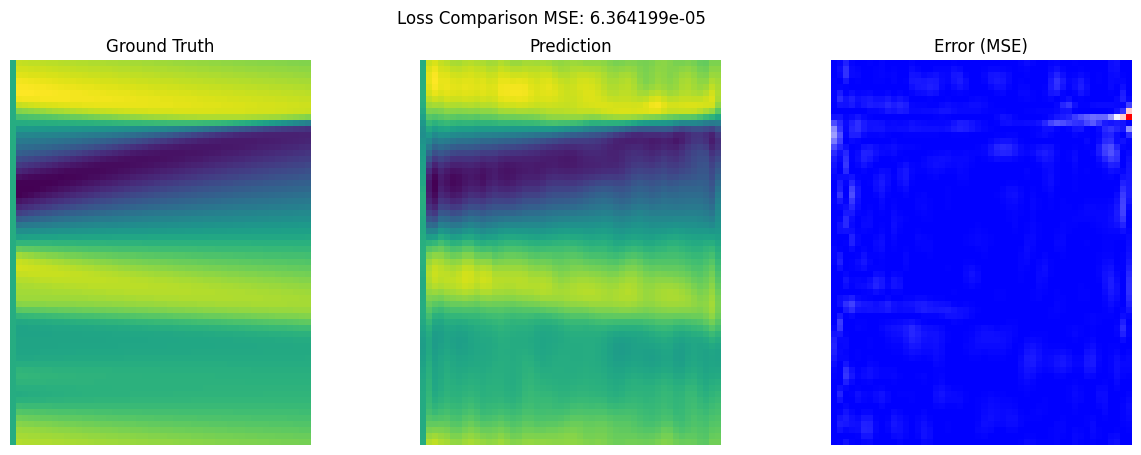

In [28]:
plot_comparison(min_loss_idx)

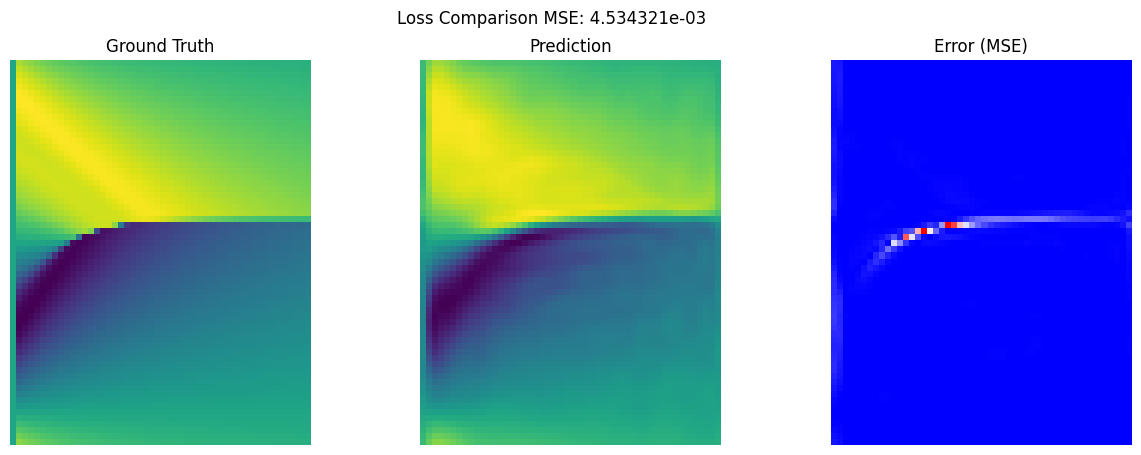

In [29]:
plot_comparison(max_loss_idx)